In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import xarray as xr
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmoocean as cmo
import warnings
warnings.filterwarnings('ignore')
from wim_dateTime import createListDateTime
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
import os
import glob
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm


def convertEgg2Num_FSD(fsd_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=fsd_egg.where(fsd_egg<99).values
    sic_num[sic_num==22]=1.65
    sic_num[sic_num==1]=1
    sic_num[sic_num==2]=10
    sic_num[sic_num==3]=60
    sic_num[sic_num==4]=300
    sic_num[sic_num==5]=1250
    sic_num[sic_num==6]=6000
    sic_num[sic_num==7]=15000
    sic_num[sic_num==8]=np.nan
    sic_num[sic_num==9]=0
    sic_num[sic_num==10]=0
    sic_num[sic_num==21]=15000
    return sic_num.astype(float)

def convertEgg2Num_SIC(sic_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=sic_egg.where(sic_egg<99).values
    sic_num[sic_num==92]=10
    sic_num[sic_num==91]=9.5
    sic_num[sic_num==90]=9
    sic_num[sic_num==89]=8.5
    sic_num[sic_num==81]=9
    sic_num[sic_num==80]=8
    sic_num[sic_num==79]=8
    sic_num[sic_num==78]=7.5
    sic_num[sic_num==70]=7
    sic_num[sic_num==68]=7
    sic_num[sic_num==67]=6.5
    sic_num[sic_num==57]=6
    sic_num[sic_num==56]=5.5
    sic_num[sic_num==46]=5
    sic_num[sic_num==45]=4.5
    sic_num[sic_num==35]=4
    sic_num[sic_num==34]=3.5
    sic_num[sic_num==24]=3
    sic_num[sic_num==23]=2.5
    sic_num[sic_num==13]=2
    sic_num[sic_num==12]=1.5
    sic_num[sic_num==60]=6
    sic_num[sic_num==50]=5
    sic_num[sic_num==40]=4
    sic_num[sic_num==30]=3
    sic_num[sic_num==20]=2
    sic_num[sic_num==10]=1
    sic_num[sic_num==98]=0
    sic_num[sic_num==2]=0.1
    sic_num[sic_num==1]=0.1
    sic_num[sic_num<=0]=0

    return sic_num.astype(float)/10


def convertEgg2Num_ITD(sic_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=sic_egg.where(sic_egg<99).values
    sic_num[sic_num==80]=0
    sic_num[sic_num==90]=np.nan
    sic_num[sic_num==92]=np.nan
    sic_num[sic_num==98]=0
    sic_num[sic_num==81]=5
    sic_num[sic_num==82]=5
    sic_num[sic_num==83]=20
    sic_num[sic_num==84]=12.5
    sic_num[sic_num==85]=22.5
    sic_num[sic_num==87]=50
    sic_num[sic_num==88]=40
    sic_num[sic_num==89]=60
    sic_num[sic_num==91]=95
    sic_num[sic_num==93]=200
    sic_num[sic_num==94]=150
    sic_num[sic_num==95]=300
    sic_num[sic_num==96]=250
    sic_num[sic_num==97]=350
    
    return sic_num.astype(float)

def readCryoSat2(list_file_N7, list_file_C2):

    grid_NSIDC='/storage/bward/obs/nsidc/NSIDC0771_CellArea_PS_N25km_v1.0.nc'
    dx_NSIDC=xr.open_dataset(grid_NSIDC)
    dx_NSIDC=dx_NSIDC.cell_area
    coord_obs="/storage/bward/obs/nsidc/NSIDC0771_LatLon_PS_N25km_v1.0.nc"
    dx_coord_obs=xr.open_dataset(coord_obs)
    lat_obs=dx_coord_obs.latitude
    lon_obs=dx_coord_obs.longitude
    # mask_lab= np.logical_or(lon_obs<=-75, lon_obs>=-43)
    # mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
    mask_SL = np.logical_and.reduce((
    lon_obs >= -75,
    lon_obs <= -57,
    lat_obs >= 45,
    lat_obs <= 51
    ))

    mask_lab = np.logical_or.reduce((
    lon_obs <= -65,
    lon_obs >= -43,
    lat_obs <= 45,
    lat_obs >= 72
    ))
    
    
    listN7=[]
    listC2=[]
    aice1d=np.array([])
    fsd1d=np.array([])
    indexF=0
    for file_N7 in list_file_N7:
        fileC2=list_file_C2[indexF]
        dx_obs_fsd=np.squeeze(xr.open_dataset(fileC2))
        dx_obs=np.squeeze(xr.open_dataset(file_N7))
        tempN7=np.squeeze(dx_obs.F17_ICECON) 
        listN7.append(tempN7)
        tempC2=np.squeeze(dx_obs_fsd.fsdrad)*2
        listC2.append(tempC2)
        
        mask_1 = np.logical_or(tempN7.values > 1, tempN7.values < 0.15)
        mask_3 = np.logical_or(tempN7.values > 1, tempN7.values > 0.8)
        mask_4 = np.logical_or(tempN7.values > 1, tempN7.values > 0.9)
        mask_2 = np.logical_or(tempC2>300, tempC2==300)   

        test_FSD = ma.masked_array(tempC2, mask=mask_1+mask_lab+mask_SL)
        test_SIC = ma.masked_array(tempN7, mask=mask_1+mask_lab+mask_SL)
        
        fsd_nan=np.nan_to_num(test_FSD) #[~np.isnan(test_FSD)]
        sic_nan=np.nan_to_num(test_SIC) #[~np.isnan(test_FSD)]

        fsd_mask=fsd_nan[~fsd_nan.mask]
        sic_mask=sic_nan[~fsd_nan.mask]
        
        aice1d=np.append(aice1d,np.squeeze(sic_mask))
        fsd1d=np.append(fsd1d,np.squeeze(fsd_mask))

    
# #         area_fsd_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_2+mask_lab+mask_lab2+mask_4)
# #         area_aice_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_3+mask_lab+mask_lab2)
        
        
#         indexF=indexF+1
        
# #     avg_aice_obs=np.nanmean(np.stack(listN7),axis=0)
# #     avg_fsd_obs=np.nanmean(np.stack(listC2),axis=0)
    
# #     avg_fsd_obs[avg_fsd_obs<=0]=np.nan
    
    return [aice1d, fsd1d]


def readIceChartfiles(list_files):
    
    grid_IC='/storage/bward/obs/iceChart/depot.cmc.ec.gc.ca/upload/mrb/caya/area.nc'
    dx_IC=xr.open_dataset(grid_IC)
    dx_IC=dx_IC.AREA
    lat_IC=dx_IC.lat
    lon_IC=dx_IC.lon
    
    mask_SL = np.logical_and.reduce((
    lon_IC >= -75,
    lon_IC <= -57,
    lat_IC >= 45,
    lat_IC <= 51
    ))

    mask_lab = np.logical_or.reduce((
    lon_IC <= -65,
    lon_IC >= -43,
    lat_IC <= 45,
    lat_IC >= 72
    ))
    
    listFA=[]
    listFB=[]
    listFC=[]

    listSA=[]
    listSB=[]
    listSC=[]

    listCA=[]
    listCB=[]
    listCC=[]
    listCT=[]

    stdCT=[]
    stdFSD=[]
    for file_IC in list_files:
#         print(file_IC)
        ds_temp=xr.open_dataset(file_IC)

        temp_FA=convertEgg2Num_FSD(np.squeeze(ds_temp.FA))
        temp_FB=convertEgg2Num_FSD(np.squeeze(ds_temp.FB))
        temp_FC=convertEgg2Num_FSD(np.squeeze(ds_temp.FC))
        temp_SA=convertEgg2Num_ITD(np.squeeze(ds_temp.SA))
        temp_SB=convertEgg2Num_ITD(np.squeeze(ds_temp.SB))
        temp_SC=convertEgg2Num_ITD(np.squeeze(ds_temp.SC))
        temp_CA=convertEgg2Num_SIC(np.squeeze(ds_temp.CA))
        temp_CB=convertEgg2Num_SIC(np.squeeze(ds_temp.CB))
        temp_CC=convertEgg2Num_SIC(np.squeeze(ds_temp.CC))
        temp_CT=convertEgg2Num_SIC(np.squeeze(ds_temp.CT))
        
#         temp_SIC=temp_CA+temp_CB+temp_CC
#         temp_SIC[temp_SIC<=0]=np.nan
#         temp_FSD=(temp_CA/temp_SIC)*temp_FA+(temp_CB/temp_SIC)*temp_FB+(temp_CC/temp_SIC)*temp_FC
        
#         mask_IC1 = np.logical_or(np.isnan(temp_CT), temp_CT<0.15)
#         mask_IC2 = np.logical_or(temp_FSD<0, temp_FSD>300)
#         mask_IC3 = np.logical_or(temp_CT>1, temp_CT>0.8)
#         mask_IC4 = np.logical_or(temp_CT>1, temp_CT>0.9)
# #         mask_IC5 = np.logical_or(temp_CT<0, FSD<-10)
    
#         area_fsd_y = ma.masked_array(dx_IC.values, mask=mask_IC1+mask_IC2+mask_labIC+mask_lab2IC+mask_IC4)
#         area_aice_y = ma.masked_array(dx_IC.values, mask=mask_IC1+mask_IC3+mask_labIC+mask_lab2IC)
    
#         stdCT.append(np.sum(np.sum(area_aice_y, axis=0))/1e6)
#         stdFSD.append(np.sum(np.sum(area_fsd_y, axis=0))/1e6)
        
        listFA.append(temp_FA)
        listFB.append(temp_FB)
        listFC.append(temp_FC)
        listSA.append(temp_SA)
        listSB.append(temp_SB)
        listSC.append(temp_SC)
        listCA.append(temp_CA)
        listCB.append(temp_CB)
        listCC.append(temp_CC)
        listCT.append(temp_CT)
        

    #     FSDA=np.stack((FSDA, convertEgg2Num_FSD(np.squeeze(ds_temp.FA)).reshape((lon.shape[0], lon.shape[1], 1))))
    FSDA=np.nanmean(np.stack(listFA),axis=0)
    FSDB=np.nanmean(np.stack(listFB),axis=0)
    FSDC=np.nanmean(np.stack(listFC),axis=0)

    ITDA=np.nanmean(np.stack(listSA),axis=0)
    ITDB=np.nanmean(np.stack(listSB),axis=0)
    ITDC=np.nanmean(np.stack(listSC),axis=0)

    SICA=np.nanmean(np.stack(listCA),axis=0)
    SICB=np.nanmean(np.stack(listCB),axis=0)
    SICC=np.nanmean(np.stack(listCC),axis=0)
    SICT=np.nanmean(np.stack(listCT),axis=0)

    SIC=SICA+SICB+SICC
    SIC[SIC<=0]=np.nan

    FSD=(SICA/SIC)*FSDA+(SICB/SIC)*FSDB+(SICC/SIC)*FSDC
    
    
    mask1 = np.logical_or(np.isnan(SICT), SICT<0.15)
    mask2 = np.logical_or(FSD<0, FSD>300)
    mask3 = np.logical_or(SICT>1, SICT>0.8)
    mask4 = np.logical_or(SICT>1, SICT>0.9)
    mask5 = np.logical_or(FSD<0, FSD<-10)

    test_FSD = ma.masked_array(FSD, mask=mask1+mask_lab+mask_SL+mask5)
    test_SIC = ma.masked_array(SICT, mask=mask1+mask_lab+mask_SL)

    fsd_1d=np.squeeze(test_FSD.reshape((test_FSD.shape[0]*test_FSD.shape[1],1)))
    sic_1d=np.squeeze(test_SIC.reshape((test_FSD.shape[0]*test_FSD.shape[1],1)))
    area_1d=np.squeeze(dx_IC.values.reshape((test_FSD.shape[0]*test_FSD.shape[1],1)))

    fsd_nan=fsd_1d[~np.isnan(fsd_1d)]
    sic_nan=sic_1d[~np.isnan(fsd_1d)]
    area_nan=area_1d[~np.isnan(fsd_1d)]

    fsd_mask=fsd_nan[~fsd_nan.mask]
    sic_mask=sic_nan[~fsd_nan.mask]
    area_mask=area_nan[~fsd_nan.mask]
    
    return [sic_mask, fsd_mask, area_mask]

In [2]:
REP_coup='/aos/home/bward/wim/post-proc/case83/avg/'
REP_IC2='/aos/home/bward/wim/post-proc/case89/avg/'
path_obs="/storage/bward/obs/nsidc/raw/"
path_obs_fsd='/storage/bward/obs/cryoSat2/nsidc/'
path_IC='/storage/bward/obs/iceChart/CIS_10km/'
monthsl=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
list_month=[1,2,3,4] #,5,6,7,8,9,10,11,12]
# monthsl=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

file_area='/aos/home/bward/wim/cice/out/case74/history/iceh_ic.2005-01-09-43200.nc'
dx_area = xr.open_dataset(file_area)
dx_area= dx_area.tarea

grid_NSIDC='/storage/bward/obs/nsidc/NSIDC0771_CellArea_PS_N25km_v1.0.nc'
dx_NSIDC=xr.open_dataset(grid_NSIDC)
dx_NSIDC=dx_NSIDC.cell_area
coord_obs="/storage/bward/obs/nsidc/NSIDC0771_LatLon_PS_N25km_v1.0.nc"
dx_coord_obs=xr.open_dataset(coord_obs)
lat_obs=dx_coord_obs.latitude
lon_obs=dx_coord_obs.longitude
# mask_lab= np.logical_or(lon_obs<=-75, lon_obs>=-43)
# mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
mask_lab= np.logical_or(lon_obs<=-65, lon_obs>=-43)
mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
    
grid_IC='/storage/bward/obs/iceChart/depot.cmc.ec.gc.ca/upload/mrb/caya/area.nc'
dx_IC=xr.open_dataset(grid_IC)
dx_IC=dx_IC.AREA
lat_IC=dx_IC.lat
lon_IC=dx_IC.lon
mask_labIC=np.logical_or(lon_IC<=-65, lon_IC>=-43)
mask_lab2IC=np.logical_or(lat_IC<=45, lat_IC>=72)

list_year=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

sic_appendC2=np.array([])
fsd_appendC2=np.array([])

sic_append_model=np.array([])
fsd_append_model=np.array([])

for mm in list_month:
    if mm != 12:
        nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2018'+str(mm+1).zfill(2)+'0100000.nc'
    else:
        nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2019010100000.nc'
        
    list_file_IC=[]
    list_file_N7=[]
    list_file_C2=[]
    
    #Read model and create mask
    pathFile_coup=REP_coup+nameFile
    dx_coup = xr.open_dataset(pathFile_coup)
    lat=dx_coup.TLAT
    lon=dx_coup.TLON

    aice=np.squeeze(dx_coup.aice)
    fsd=np.squeeze(dx_coup.fsdrad)
    
    maskLab=aice.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
    aice_1d=np.squeeze(aice.where(maskLab>0.15).values.reshape((aice.shape[0]*aice.shape[1],1)))
    fsd_1d=np.squeeze(fsd.where(maskLab>0.15).values.reshape((fsd.shape[0]*fsd.shape[1],1)))
    
    aice_1d=aice_1d[~np.isnan(aice_1d)]
    fsd_1d=fsd_1d[~np.isnan(fsd_1d)]
    
    sic_append_model=np.append(sic_append_model,aice_1d)
    fsd_append_model=np.append(fsd_append_model,fsd_1d)
    
    #Create a list of file to read for each dataset
    for yyyy in list_year:
        file_pattern_N7="NSIDC0051_SEAICE_PS_N25km_"+str(yyyy)+str(mm).zfill(2)+"_v2.0.nc"
        filePath_N7=os.path.join(path_obs, file_pattern_N7)
        tempFileN7=glob.glob(filePath_N7)
        
        file_pattern_C2="cryosat_fsd_"+str(yyyy)+str(mm).zfill(2)+"_nsidc.nc"
        filePath_C2=os.path.join(path_obs_fsd, file_pattern_C2)
        tempFileC2=glob.glob(filePath_C2)
        
        file_pattern_IC='CIS_10km_'+str(yyyy)+str(mm).zfill(2)+'*'+'.nc'
        filePath_IC=os.path.join(path_IC, file_pattern_IC)
        tempFileL=glob.glob(filePath_IC)
        
        for f in tempFileL:
            list_file_IC.append(f)
            
        for fN7 in tempFileN7:
            list_file_N7.append(fN7)
            
        for fC2 in tempFileC2:
            list_file_C2.append(fC2)

    #Nimbus-7000 stuff
    obs_data=readCryoSat2(list_file_N7, list_file_C2) 
    sic_1d=obs_data[0]
    fsd_1d=obs_data[1]
    
    fsd_appendC2=np.append(fsd_appendC2,fsd_1d)
    sic_appendC2=np.append(sic_appendC2,sic_1d)
    

fsd_appendIC=np.array([])
sic_appendIC=np.array([])
area_appendIC=np.array([])
           
for yyyy in list_year:
    for mm in list_month:
        list_file_IC=[]
        list_file_N7=[]
        list_file_C2=[]
        if mm != 12:
            nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2018'+str(mm+1).zfill(2)+'0100000.nc'
        else:
            nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2019010100000.nc'
    
        #Create a list of file to read for each dataset
        file_pattern_N7="NSIDC0051_SEAICE_PS_N25km_"+str(yyyy)+str(mm).zfill(2)+"_v2.0.nc"
        filePath_N7=os.path.join(path_obs, file_pattern_N7)
        tempFileN7=glob.glob(filePath_N7)
        
        file_pattern_C2="cryosat_fsd_"+str(yyyy)+str(mm).zfill(2)+"_nsidc.nc"
        filePath_C2=os.path.join(path_obs_fsd, file_pattern_C2)
        tempFileC2=glob.glob(filePath_C2)
        
        file_pattern_IC='CIS_10km_'+str(yyyy)+str(mm).zfill(2)+'*'+'.nc'
        filePath_IC=os.path.join(path_IC, file_pattern_IC)
        tempFileL=glob.glob(filePath_IC)
        
        for f in tempFileL:
            list_file_IC.append(f)
            
        for fN7 in tempFileN7:
            list_file_N7.append(fN7)
            
        for fC2 in tempFileC2:
            list_file_C2.append(fC2)

#     #Nimbus-7000 stuff
#         print(list_file_IC)
        IC_data=readIceChartfiles(list_file_IC) 
        FSD=IC_data[1]
        SICT=IC_data[0]
        areaT=IC_data[2]
        
        fsd_appendIC=np.append(fsd_appendIC,FSD)
        sic_appendIC=np.append(sic_appendIC,SICT)
        area_appendIC=np.append(area_appendIC,areaT)

#     fsd_append=np.append(fsd_append,fsd_1d)

In [3]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

num_bins=100

#----Ice charts ----#
condition_1 = np.logical_and(sic_appendIC >= 0.8, fsd_appendIC >= 300)
condition_2 = np.logical_and(sic_appendIC >= 0.8, fsd_appendIC < 300)
condition_3 = np.logical_and(sic_appendIC < 0.8, fsd_appendIC >= 300)
condition_4 = np.logical_and(sic_appendIC < 0.8, fsd_appendIC < 300)

# Count the number of points for each quantity
count_1 = np.count_nonzero(condition_1)
count_2 = np.count_nonzero(condition_2)
count_3 = np.count_nonzero(condition_3)
count_4 = np.count_nonzero(condition_4)

# Calculate the fractions
total_points = len(sic_appendIC)
fraction_1 = count_1 / total_points*100
fraction_2 = count_2 / total_points*100
fraction_3 = count_3 / total_points*100
fraction_4 = count_4 / total_points*100

counts, x_edges, y_edges = np.histogram2d(sic_appendIC, fsd_appendIC, bins=num_bins)

# Flatten the counts array
counts_flat = counts.flatten()

# Get the bin indices for each data point
x_indices = np.clip(np.digitize(sic_appendIC, x_edges) - 1, 0, num_bins - 1)
y_indices = np.clip(np.digitize(fsd_appendIC, y_edges) - 1, 0, num_bins - 1)

# Convert the indices to a single index
index = np.ravel_multi_index((x_indices, y_indices), counts.shape)

# Find the nearest count value for each data point
nearest_counts = counts_flat[index]

percentage=nearest_counts/np.sum(nearest_counts)*100

slope, intercept = np.polyfit(sic_appendIC, np.log(fsd_appendIC), 1)
x_fit = np.linspace(min(sic_appendIC), max(sic_appendIC), 100)
y_fit = np.exp(slope * x_fit + intercept)

correlation, _ = pearsonr(sic_appendIC, np.log(fsd_appendIC))

y_predicted = np.exp(slope * sic_appendIC + intercept)

r2 = r2_score(np.log(fsd_appendIC), np.log(y_predicted))

# Calculate R-squared
# y_mean = np.mean(np.log(fsd_appendIC))
# ss_total = np.sum((np.log(fsd_appendIC) - y_mean) ** 2)
# ss_residual = np.sum((np.log(fsd_appendIC) - np.log(y_predicted)) ** 2)
# r2 = 1 - (ss_residual / ss_total)

# print(r2)


#----- Cryosat-2----#

condition_1 = np.logical_and(sic_appendC2 > 0.8, fsd_appendC2 > 300)
condition_2 = np.logical_and(sic_appendC2 > 0.8, fsd_appendC2 <= 300)
condition_3 = np.logical_and(sic_appendC2 <= 0.8, fsd_appendC2 >= 300)
condition_4 = np.logical_and(sic_appendC2 <= 0.8, fsd_appendC2 <= 300)

# Count the number of points for each quantity
count_1 = np.count_nonzero(condition_1)
count_2 = np.count_nonzero(condition_2)
count_3 = np.count_nonzero(condition_3)
count_4 = np.count_nonzero(condition_4)

# Calculate the fractions
total_pointsC2 = len(sic_appendC2)
fraction_1C2 = count_1 / total_pointsC2*100
fraction_2C2 = count_2/total_pointsC2*100
fraction_3C2 = count_3 / total_pointsC2*100
fraction_4C2 = (count_4)/total_pointsC2*100

sic_appendC2=sic_appendC2[fsd_appendC2>0]
fsd_appendC2=fsd_appendC2[fsd_appendC2>0]

# slopeC2, interceptC2 = np.polyfit(sic_appendC2, np.log(fsd_appendC2), 1)
# x_fitC2 = np.linspace(min(sic_appendC2), max(sic_appendC2), 100)
# y_fitC2 = np.exp(slopeC2 * x_fitC2 + interceptC2)

# correlation, _ = pearsonr(sic_appendC2, np.log(fsd_appendC2))

# y_predictedC2 = np.exp(slopeC2 * sic_appendC2 + interceptC2)
# r2C2 = r2_score(np.log(fsd_appendC2), np.log(y_predictedC2))

slopeC2, interceptC2 = np.polyfit(sic_appendC2,fsd_appendC2, 1)
x_fitC2 = np.linspace(min(sic_appendC2), max(sic_appendC2), 100)
y_fitC2 =slopeC2 * x_fitC2 + interceptC2

correlation, _ = pearsonr(sic_appendC2, fsd_appendC2)

y_predictedC2 = slopeC2 * sic_appendC2 + interceptC2
r2C2 = r2_score(fsd_appendC2, y_predictedC2)

countsC2, x_edgesC2, y_edgesC2 = np.histogram2d(sic_appendC2, fsd_appendC2, bins=num_bins)

# Flatten the counts array
counts_flatC2 = countsC2.flatten()

# Calculate the bin indices
x_indicesC2 = np.clip(np.digitize(sic_appendC2, x_edgesC2) - 1, 0, num_bins - 1)
y_indicesC2 = np.clip(np.digitize(fsd_appendC2, y_edgesC2) - 1, 0, num_bins - 1)

# Convert the indices to a single index
indexC2 = np.ravel_multi_index((x_indicesC2, y_indicesC2), countsC2.shape)

nearest_countsC2 = counts_flatC2[indexC2]

percentageC2=nearest_countsC2/np.sum(nearest_countsC2)*100

#----- Model----#

slopeMod, interceptMod = np.polyfit(sic_append_model, np.log(fsd_append_model), 1)
x_fitMod = np.linspace(min(sic_append_model), max(sic_append_model), 100)
y_fitMod = np.exp(slopeMod * x_fitMod + interceptMod)

correlation, _ = pearsonr(sic_append_model, np.log(fsd_append_model))

y_predictedMod = np.exp(slopeMod * sic_append_model + interceptMod)
r2Mod = r2_score(np.log(fsd_append_model), np.log(y_predictedMod))

# print(correlation, r2Mod)

condition_1 = np.logical_and(sic_append_model > 0.8, fsd_append_model > 300)
condition_2 = np.logical_and(sic_append_model > 0.8, fsd_append_model <= 300)
condition_3 = np.logical_and(sic_append_model <= 0.8, fsd_append_model >= 300)
condition_4 = np.logical_and(sic_append_model <= 0.8, fsd_append_model <= 300)

# Count the number of points for each quantity
count_1 = np.count_nonzero(condition_1)
count_2 = np.count_nonzero(condition_2)
count_3 = np.count_nonzero(condition_3)
count_4 = np.count_nonzero(condition_4)

# Calculate the fractions
total_pointsMod = len(sic_append_model)
fraction_1mod = count_1 / total_pointsMod*100
fraction_2mod = count_2/total_pointsMod*100
fraction_3mod = count_3 / total_pointsMod*100
fraction_4mod = count_4/total_pointsMod*100

countsMod, x_edgesMod, y_edgesMod = np.histogram2d(sic_append_model, fsd_append_model, bins=num_bins)

# Flatten the counts array
counts_flatMod = countsMod.flatten()

# Get the bin indices for each data point
x_indicesMod = np.clip(np.digitize(sic_append_model, x_edgesMod) - 1, 0, num_bins - 1)
y_indicesMod = np.clip(np.digitize(fsd_append_model, y_edgesMod) - 1, 0, num_bins - 1)

# Convert the indices to a single index
indexMod = np.ravel_multi_index((x_indicesMod, y_indicesMod), countsMod.shape)

# Find the nearest count value for each data point
nearest_countsMod = counts_flatMod[indexMod]

percentageMod=nearest_countsMod/np.sum(nearest_countsMod)*100

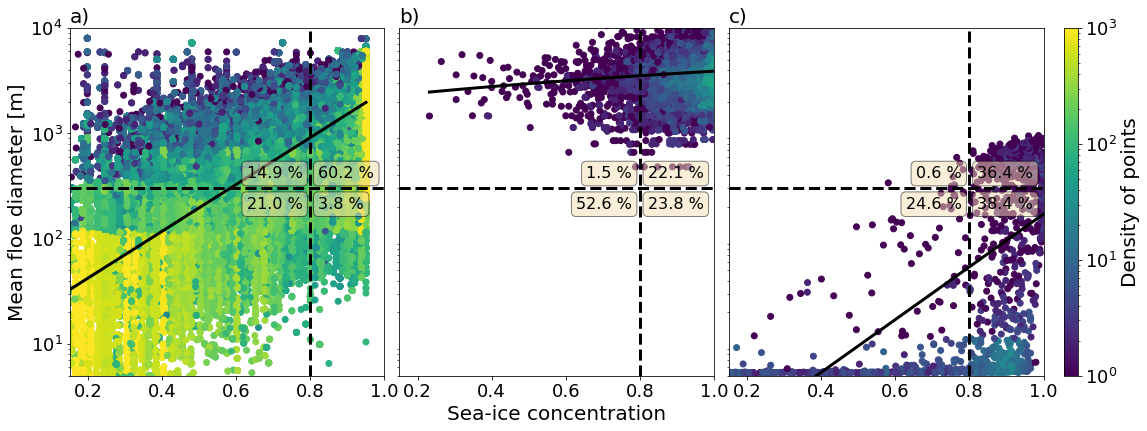

In [4]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=[16, 6])
gs = GridSpec(1,4,figure=fig, hspace=0.05, wspace=0.06, width_ratios=[1, 1, 1, 0.08])
fig.subplots_adjust(left=0.06, right=0.94, bottom=0.125, top=0.93) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# slope, intercept = np.polyfit(sic_append, np.log(fsd_append), 1)
# x_fit = np.linspace(min(sic_append), max(sic_append), 100)
# y_fit = np.exp(slope * x_fit + intercept)


#----Ice charts---#

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)

sc = ax1.scatter(sic_appendIC, fsd_appendIC, c=nearest_counts, cmap='viridis', norm=LogNorm(vmin=1, vmax=1000))
ax1.plot(x_fit, y_fit, color='k', linewidth=3)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(y=300, color='k', linestyle='--', linewidth=3)
plt.axvline(x=0.8, color='k', linestyle='--', linewidth=3)
ax1.set_ylabel("Mean floe diameter [m]", size=20)
# ax1.set_xlabel("Sea-ice concentration", size=28)

# extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
# mask_1=np.logical_or(counts<1, counts==0)
# test=ma.masked_array(counts, mask=mask_1)
# # sc = ax.scatter(x, y, c=counts.flatten(), cmap='viridis', alpha=0.5)
# pcolor = axes.pcolor(x_edges, y_edges, test.T, cmap='viridis',vmin=0, vmax=75, alpha=0.6,snap=True, shading='auto')
ax1.set_xlim([0.15,0.96])
ax1.set_yscale('log')
ax1.set_ylim(5, 10000)
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
# axes.text(0.2, 100,r"$\alpha$ = {:.2f}".format(slope) , fontsize=24, color='black')


ax1.text(0.79, 0.515, f"{fraction_2:.1f} %", transform=ax1.transAxes, color='k', fontsize=16, ha='left', va='top', bbox=props)
ax1.text(0.79, 0.56, f"{fraction_1:.1f} %", transform=ax1.transAxes, color='k', fontsize=16,ha='left', va='bottom', bbox=props)
ax1.text(0.74, 0.515, f"{fraction_4:.1f} %", transform=ax1.transAxes, color='k', fontsize=16, ha='right', va='top',  bbox=props)
ax1.text(0.74, 0.56, f"{fraction_3:.1f} %", transform=ax1.transAxes, color='k', fontsize=16,ha='right', va='bottom',  bbox=props)

# ax1.text(1, 0.52, f"{fraction_2:.2f} %", transform=ax1.transAxes, color='k', fontsize=26, ha='right', va='top')
# ax1.text(1, 0.55, f"{fraction_1:.2f} %", transform=ax1.transAxes, color='k', fontsize=26,ha='right', va='bottom')
# ax1.text(0.5, 0.52, f"{fraction_4:.2f} %", transform=ax1.transAxes, color='k', fontsize=26, ha='right', va='top')
# ax1.text(0.5, 0.55, f"{fraction_3:.2f} %", transform=ax1.transAxes, color='k', fontsize=26,ha='right', va='bottom')
# ax1.text(0.03, 0.45, "FSD-MIZ", transform=ax1.transAxes, fontsize=28, color='red', ha='left', va='bottom')
# ax1.text(0.55, 0.05, 'SIC-MIZ', transform=ax1.transAxes, color= 'dodgerblue', fontsize=28, ha='left', va='bottom')
# cax = fig.add_axes([ax1.get_position().x0, 0.04, ax1.get_position().width, 0.02])
ax1.set_title('a)', loc='left', fontsize=20)


# ---Cryosat-2 ---#

ax2 = fig.add_subplot(gs[0, 1])
plt.sca(ax2)
# slope, intercept = np.polyfit(sic_append, np.log(fsd_append), 1)
# x_fit = np.linspace(min(sic_append), max(sic_append), 100)
# y_fit = np.exp(slope * x_fit + intercept)

sc = ax2.scatter(sic_appendC2, fsd_appendC2, c=nearest_countsC2, cmap='viridis', norm=LogNorm(vmin=1, vmax=1000))
ax2.plot(x_fitC2, y_fitC2, color='k', linewidth=3)
# axes.plot(x_fit, y_fit, color='k', linewidth=3)
# Create density plot
# pcolor=axes.scatter(x_sorted, y_sorted, c=density_sorted, cmap='viridis')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(y=300, color='k', linestyle='--', linewidth=3)
plt.axvline(x=0.8, color='k', linestyle='--', linewidth=3)
# ax2.set_ylabel("Mean floe diameter [m]", size=28)
ax2.set_xlabel("Sea-ice concentration", size=20)
ax2.set_xlim([0.15,1])
# ax2.set_yscale('log')
# axes.text(0.2, 100,r"$\alpha$ = {:.2f}".format(slope) , fontsize=24, color='black')
ax2.set_yscale('log')
ax2.set_ylim(5, 10000)
ax2.set_title('b)', loc='left', fontsize=20)
ax2.set_yticks([])
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])

ax2.text(0.79, 0.515, f"{fraction_2C2:.1f} %", transform=ax2.transAxes, color='k', fontsize=16, ha='left', va='top', bbox=props)
ax2.text(0.79, 0.56, f"{fraction_1C2:.1f} %", transform=ax2.transAxes, color='k', fontsize=16,ha='left', va='bottom', bbox=props)
ax2.text(0.74, 0.515, f"{fraction_4C2:.1f} %", transform=ax2.transAxes, color='k', fontsize=16, ha='right', va='top',  bbox=props)
ax2.text(0.74, 0.56, f"{fraction_3C2:.1f} %", transform=ax2.transAxes, color='k', fontsize=16,ha='right', va='bottom',  bbox=props)


# ax2.text(1, 0.52, f"{fraction_2C2:.2f} %", transform=ax2.transAxes, color='k', fontsize=26, ha='right', va='top')
# ax2.text(1, 0.55, f"{fraction_1C2:.2f} %", transform=ax2.transAxes, color='k', fontsize=26,ha='right', va='bottom')
# ax2.text(0.5, 0.52, f"{fraction_4C2:.2f} %", transform=ax2.transAxes, color='k', fontsize=26, ha='right', va='top')
# ax2.text(0.5, 0.55, f"{fraction_3C2:.2f} %", transform=ax2.transAxes, color='k', fontsize=26,ha='right', va='bottom')
# ax2.text(0.03, 0.45, "FSD-MIZ", transform=ax2.transAxes, fontsize=28, color='red', ha='left', va='bottom')
# ax2.text(0.5, 0.05, 'SIC-MIZ', transform=ax2.transAxes, color= 'dodgerblue', fontsize=28, ha='left', va='bottom')


ax3 = fig.add_subplot(gs[0, 2])
plt.sca(ax3)
# slope, intercept = np.polyfit(sic_append, np.log(fsd_append), 1)
# x_fit = np.linspace(min(sic_append), max(sic_append), 100)
# y_fit = np.exp(slope * x_fit + intercept)

sc = ax3.scatter(sic_append_model, fsd_append_model, c=nearest_countsMod, cmap='viridis',norm=LogNorm(vmin=1, vmax=1000))
ax3.plot(x_fitMod, y_fitMod, color='k', linewidth=3)
# axes.plot(x_fit, y_fit, color='k', linewidth=3)
# Create density plot
# pcolor=axes.scatterx_sorted, y_sorted, c=density_sorted, cmap='viridis')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(y=300, color='k', linestyle='--', linewidth=3)
plt.axvline(x=0.8, color='k', linestyle='--', linewidth=3)
# ax3.set_ylabel("Mean floe diameter [m]", size=28)
# ax3.set_xlabel("Sea-ice concentration", size=28)
ax3.set_xlim([0.15,1])
ax3.set_yscale('log')
# axes.text(0.2, 100,r"$\alpha$ = {:.2f}".format(slope) , fontsize=24, color='black')
# axes.set_yscale('log')
ax3.set_ylim(5, 10000)
ax3.set_yticks([])
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])

# ax3.text(0.985, 0.07, f"{fraction_2mod:.2f} %", transform=ax3.transAxes, color='k', fontsize=16, ha='right', va='top', bbox=props)
# ax3.text(0.985, 0.925, f"{fraction_1mod:.2f} %", transform=ax3.transAxes, color='k', fontsize=16,ha='right', va='bottom', bbox=props)
# ax3.text(0.02, 0.07, f"{fraction_4mod:.2f} %", transform=ax3.transAxes, color='k', fontsize=16, ha='left', va='top',  bbox=props)
# ax3.text(0.02, 0.925, f"{fraction_3mod:.2f} %", transform=ax3.transAxes, color='k', fontsize=16,ha='left', va='bottom',  bbox=props)
ax3.text(0.79, 0.515, f"{fraction_2mod:.1f} %", transform=ax3.transAxes, color='k', fontsize=16, ha='left', va='top', bbox=props)
ax3.text(0.79, 0.56, f"{fraction_1mod:.1f} %", transform=ax3.transAxes, color='k', fontsize=16,ha='left', va='bottom', bbox=props)
ax3.text(0.74, 0.515, f"{fraction_4mod:.1f} %", transform=ax3.transAxes, color='k', fontsize=16, ha='right', va='top',  bbox=props)
ax3.text(0.74, 0.56, f"{fraction_3mod:.1f} %", transform=ax3.transAxes, color='k', fontsize=16,ha='right', va='bottom',  bbox=props)

# ax3.text(0.03, 0.58, "FSD-MIZ", transform=ax3.transAxes, fontsize=20, color='red', ha='left', va='bottom')
# ax3.text(0.5, 0.05, 'SIC-MIZ', transform=ax3.transAxes, color= 'dodgerblue', fontsize=20, ha='left', va='bottom')
ax3.set_title('c)', loc='left', fontsize=20)

cax = fig.add_subplot(gs[0,3], aspect=25)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
#     cb.set_label('Mean floe diameter model [m]', size=20)
#     cb=plt.colorbar(sc_obs, ax=axes[2], shrink=0.35)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Density of points', size=20)
# axes.text(0.03, 0.05, f"{fraction_4C2:.2f} %", transform=axes.transAxes, fontsize=24, ha='left', va='bottom')

# cb=plt.colorbar(sc, ax=ax1, shrink=0.75)
# cb.ax.tick_params(labelsize=18)
# cb.ax.tick_params(labelsize=18)
# #     cb.set_label('Mean floe diameter model [m]', size=20)
# #     cb=plt.colorbar(sc_obs, ax=axes[2], shrink=0.35)
# cb.ax.tick_params(labelsize=18)
# cb.ax.tick_params(labelsize=18)
# cb.set_label('Density of points', size=20)

plt.savefig('fsd_sic_labrador_winter_2010-2018_CIS_Cryo2_CTRL.png',dpi='figure',format='png',metadata=None)

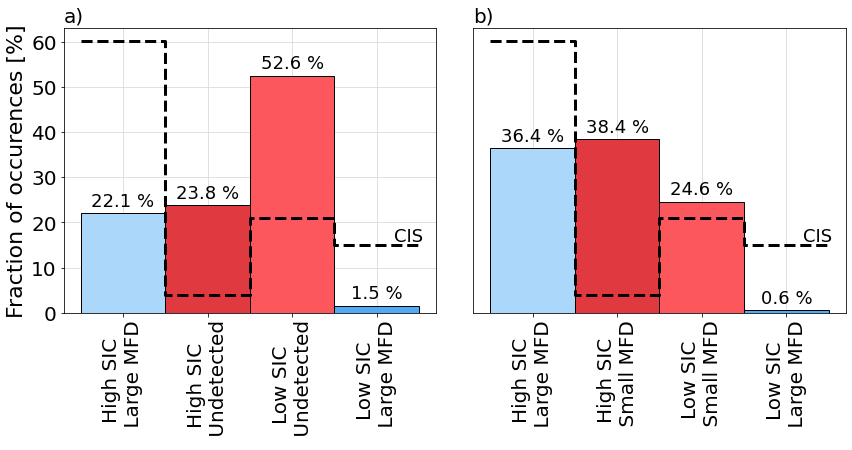

In [374]:
import matplotlib.pyplot as plt
import numpy as np

listFracMod=[fraction_1mod,fraction_2mod,fraction_4mod,fraction_3mod]
listFracCIS=[fraction_1,fraction_2, fraction_4,fraction_3]
listFracC2=[fraction_1C2,fraction_2C2, fraction_4C2,fraction_3C2]

fig = plt.figure(figsize=[12, 6])
fig.subplots_adjust(left=0.075, right=0.98, bottom=0.29, top=0.95) 
gs = GridSpec(1,2,figure=fig, hspace=0.1, wspace=0.1, width_ratios=[1, 1])

# Sample data
dataset1 = listFracCIS
dataset2 = listFracC2
dataset3 = listFracMod

# Set the colormap
colours_high=["#ff5a5f", "#c81d25"]
colours_low=["#2196f3", "#bbdefb"]

cmap_1 = mpl.colors.LinearSegmentedColormap.from_list("map0", colours_high, N=256)
norm_1=mpl.colors.Normalize(0.7, 1)

cmap_2 = mpl.colors.LinearSegmentedColormap.from_list("map1", colours_low, N=256)
norm_2=mpl.colors.Normalize(0, 0.3)

# cmap_3 = mpl.colors.LinearSegmentedColormap.from_list("map2", colours_high, N=256)
# norm_3=mpl.colors.Normalize(dataset1[2], dataset2[2])

# cmap_4 = mpl.colors.LinearSegmentedColormap.from_list("map3", colours_low, N=256)
# norm_4 = mpl.colors.Normalize(dataset2[3], dataset1[3])
# Create the color values based on the data range

# norm = plt.Normalize(min(dataset1), max(dataset1))
# colors1 = cmap(norm(dataset1))

# norm = plt.Normalize(min(dataset2), max(dataset2))
# colors2 = cmap(norm(dataset2))

# norm = plt.Normalize(min(dataset3), max(dataset3))
# colors3 = cmap(norm(dataset3))

# # Create the x-axis labels
labels = ['Label 1', 'Label 2', 'Label 3']

# Set the width of each bar
bar_width = 0.25

# Calculate the positions of the bars on the x-axis
group_width = bar_width *4  # Width for each group
x = np.arange(len(labels))

# Calculate the positions of the bars on the x-axis
x1 = np.arange(x[1]-bar_width/2,x[1]+group_width+bar_width/2,bar_width)
x2 = np.arange(x[1],x[1]+group_width,bar_width)

# # # Plot the bars for each dataset
step_x=[1.125, 1.625, 1.625, 2.125]

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
# axes.bar(x2+bar_width, dataset1, width=bar_width, label='Dataset 1',edgecolor='black', alpha=0, zorder=2)
ax1.step(step_x,dataset1,'k', where='mid',linewidth=3, linestyle='--')
# axes.bar(x2+bar_width,dataset1,width=bar_width, label='Dataset 2', edgecolor='black', alpha=1, fill=False, linewidth=3, zorder=4)
bar1=ax1.bar(x2[0]+bar_width, dataset2[0], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_2(norm_2(dataset2[0]/(dataset2[0]+dataset1[0]))), zorder=2) #, width=bar_width, label='Dataset 2')
bar2=ax1.bar(x2[1]+bar_width, dataset2[1], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_1(norm_1(dataset2[1]/(dataset2[1]+dataset1[1]))), zorder=2) #, width=bar_width, label='Dataset 2')
bar3=ax1.bar(x2[2]+bar_width, dataset2[2], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_1(norm_1(dataset2[2]/(dataset2[2]+dataset1[2]))), zorder=2) #, width=bar_width, label='Dataset 2')
bar4=ax1.bar(x2[3]+bar_width, dataset2[3], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_2(norm_2(dataset2[3]/(dataset2[3]+dataset1[3]))), zorder=2) #, width=bar_width, label='Dataset 2')
ax1.bar_label(bar1, labels=[f'{dataset2[0]:,.1f} %'], padding=3, color='black', fontsize=18)
ax1.bar_label(bar2, labels=[f'{dataset2[1]:,.1f} %'], padding=3, color='black', fontsize=18) 
ax1.bar_label(bar3, labels=[f'{dataset2[2]:,.1f} %'], padding=3, color='black', fontsize=18) 
ax1.bar_label(bar4, labels=[f'{dataset2[3]:,.1f} %'], padding=3, color='black', fontsize=18) 
ax1.set_title('a)', loc='left', fontsize=20)
ax1.text(0.965, 0.235, "CIS", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')
# ax1.text(0.94, 0.24, f"{fraction_3:.1f} %", transform=ax1.transAxes, color='k', fontsize=18, ha='right', va='bottom')
# ax1.text(0.71, 0.335, f"{fraction_4:.1f} %", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')
# ax1.text(0.46, 0.11, f"{fraction_2:.1f} %", transform=ax1.transAxes, color='k', fontsize=18, ha='right', va='top')
# ax1.text(0.26, 0.95, f"{fraction_1:.1f} %", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')
# ax1.text(1.06, 0.215, "CIS", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')


# axes.bar(x3+bar_width*3/2, dataset3, width=bar_width, label='Dataset 3', edgecolor='black', color=colors3, zorder=2)
ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=1.0, zorder=-1)
ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=1.0, zorder=-1)
# axes.set_xlim(0, 3.25)
plt.xticks([1.25, 1.5, 1.75, 2])

xtick_labels = ["High SIC \n Large MFD", 'High SIC \n Undetected', 'Low SIC \n Undetected', 'Low SIC \n Large MFD']
ax1.set_xticklabels(xtick_labels, rotation=90)
ax1.set_ylabel("Fraction of occurences [%]", size=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax2 = fig.add_subplot(gs[0, 1])
plt.sca(ax2)
# axes.bar(x2+bar_width, dataset1, width=bar_width, label='Dataset 1',edgecolor='black', alpha=0, zorder=2)
ax2.step(step_x,dataset1,'k', where='mid',linewidth=3, linestyle='--')
# axes.bar(x2+bar_width,dataset1,width=bar_width, label='Dataset 2', edgecolor='black', alpha=1, fill=False, linewidth=3, zorder=4)
bar1=ax2.bar(x2[0]+bar_width, dataset3[0], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_2(norm_2(dataset2[0]/(dataset2[0]+dataset1[0]))), zorder=2) #, width=bar_width, label='Dataset 2')
bar2=ax2.bar(x2[1]+bar_width, dataset3[1], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_1(norm_1(dataset2[1]/(dataset2[1]+dataset1[1]))), zorder=2) #, width=bar_width, label='Dataset 2')
bar3=ax2.bar(x2[2]+bar_width, dataset3[2], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_1(norm_1(dataset2[2]/(dataset2[2]+dataset1[2]))), zorder=2) #, width=bar_width, label='Dataset 2')
bar4=ax2.bar(x2[3]+bar_width, dataset3[3], width=bar_width, label='Dataset 2', edgecolor='black', color=cmap_2(norm_2(dataset2[3]/(dataset2[3]+dataset1[3]))), zorder=2) #, width=bar_width, label='Dataset 2')
ax2.bar_label(bar1, labels=[f'{dataset3[0]:,.1f} %'], padding=3, color='black', fontsize=18)
ax2.bar_label(bar2, labels=[f'{dataset3[1]:,.1f} %'], padding=3, color='black', fontsize=18) 
ax2.bar_label(bar3, labels=[f'{dataset3[2]:,.1f} %'], padding=3, color='black', fontsize=18) 
ax2.bar_label(bar4, labels=[f'{dataset3[3]:,.1f} %'], padding=3, color='black', fontsize=18) 
ax2.set_title('b)', loc='left', fontsize=20)
ax2.text(0.965, 0.235, "CIS", transform=ax2.transAxes, color='k', fontsize=18,ha='right', va='bottom')
# ax1.text(0.94, 0.24, f"{fraction_3:.1f} %", transform=ax1.transAxes, color='k', fontsize=18, ha='right', va='bottom')
# ax1.text(0.71, 0.335, f"{fraction_4:.1f} %", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')
# ax1.text(0.46, 0.11, f"{fraction_2:.1f} %", transform=ax1.transAxes, color='k', fontsize=18, ha='right', va='top')
# ax1.text(0.26, 0.95, f"{fraction_1:.1f} %", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')
# ax1.text(1.06, 0.215, "CIS", transform=ax1.transAxes, color='k', fontsize=18,ha='right', va='bottom')


# axes.bar(x3+bar_width*3/2, dataset3, width=bar_width, label='Dataset 3', edgecolor='black', color=colors3, zorder=2)
ax2.grid(which="major", axis='x', color='#DAD8D7', alpha=1.0, zorder=-1)
ax2.grid(which="major", axis='y', color='#DAD8D7', alpha=1.0, zorder=-1)
# axes.set_xlim(0, 3.25)
plt.xticks([1.25, 1.5, 1.75, 2])

xtick_labels = ["High SIC \n Large MFD", 'High SIC \n Small MFD', 'Low SIC \n Small MFD', 'Low SIC \n Large MFD']
ax2.set_xticklabels(xtick_labels, rotation=90)
# ax2.set_ylabel("Fraction of occurences [%]", size=24)
plt.xticks(fontsize=20)
ax2.set_yticks([])
plt.yticks(fontsize=20)

# # Add labels and a title
# plt.xlabel('X-axis labels')
# plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
# plt.ylabel('Y-axis values')
# plt.title('Bar Chart Example')

# # Add a legend
# plt.legend()
# hist=np.zeros(len(fsd_cat)-1)
# binCenter=[]
# binSpread=[]
# for b in range(len(fsd_cat)-1):
#     binCenter.append((fsd_cat[b]+fsd_cat[b+1])/2)
#     binSpread.append(fsd_cat[b+1]-fsd_cat[b])
        
# for ncat in range(len(fsd_cat)):
#     if ncat < len(fsd_cat)-1:
#         lower_bound=fsd_cat[ncat]
#         upper_bound=fsd_cat[ncat+1]
#         count_fsd=fsd_append[np.logical_and(fsd_append>lower_bound, fsd_append<=upper_bound)]
    
#         hist[ncat]=len(count_fsd)
# #     else:
# #         lower_bound=fsd_cat[ncat]
# #         upper_bound=np.Inf
    


# fig, axes = plt.subplots(1,1,figsize=[14,8.75])
# axes.bar(binCenter, hist, width = np.array(binSpread), edgecolor='black',alpha=0.75)
plt.savefig('hist_regimes_labrador_winter_2010-2018_Cryo2_CTRL.png',dpi='figure',format='png',metadata=None)

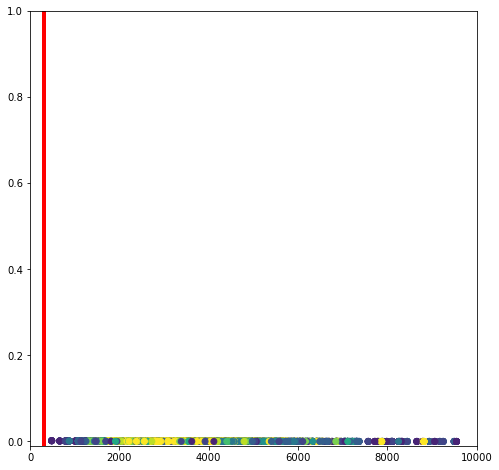

In [51]:
fig, axes = plt.subplots(figsize=[8,8])

perim=sic_appendC2/fsd_appendC2
sc = axes.scatter(fsd_appendC2, perim, c=nearest_countsC2, cmap='viridis', vmin=0, vmax=10)
axes.set_ylim([-0.01, 1])
axes.set_xlim([0,10000])
plt.axvline(x=300, color='r', linestyle='-', linewidth=4)
#, c=nearest_counts, cmap='viridis', vmin=0, vmax=1000)